In [1]:
import pickle
import numpy as np
import pandas as pd
import os
from MINE.gtm import GTM
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 20, 15
from tqdm import tqdm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D

import warnings
warnings.filterwarnings('ignore')

SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def flatten_dict(d):
    if not isinstance(d, dict):
#         if isinstance(d, np.ndarray):
#             return [list(d)]
        return [[d]]
    result = []
    for k, v in d.items():
        flattened = flatten_dict(v)
        for f in flattened:
            result.append([k] + f)
    return result

In [3]:
def recurrent_extraction_cmi(d):
    if isinstance(d, list) or isinstance(d, tuple):
        return [d[0], d[-1]]
    result = {}
    for key, value in d.items():
        result[key] = recurrent_extraction_cmi(value)
    return result

In [4]:
def load_results(path, neighbours):
    if neighbours:
        columns = ['gamma', 'n', 'c', 'method', 'k', 'seed', 'tmp']
    else:
        columns = ['gamma', 'n', 'c', 'method', 'seed', 'tmp']
    with open(path, 'rb') as fd:
        results = pickle.load(fd)
    cmis = recurrent_extraction_cmi(results)
    cmis = pd.DataFrame(flatten_dict(cmis), columns=columns)
    cmis.loc[:, ['estimation', 'true_cmi']] = cmis.tmp.to_list()
    cmis = cmis.drop(columns='tmp')
    cmis.loc[:, 'residual'] = cmis.true_cmi - cmis.estimation
    
    return cmis

def load_results_csv(path):
    cmis = pd.read_csv(path)
    cmis['method'] = 'ksg'
    cmis.loc[:, 'residual'] = cmis.true_cmi - cmis.estimation
    return cmis

In [5]:
def aggregate_results(cmis, neighbours):
    if neighbours:
        columns = ['gamma', 'n', 'c', 'method', 'k']
    else:
        columns = ['gamma', 'n', 'c', 'method']
    agg = cmis.groupby(columns).agg({
    'estimation': lambda x: np.mean(x),
    'true_cmi': lambda x: x.iloc[0],
    'residual': [lambda x: np.sqrt((x**2).mean()), lambda x: np.std(x) / np.sqrt(len(x))]
})
    agg.columns = ['estimation_avg', 'true_cmi', 'rmse', 'rmse_std']
    agg['rmse_rel'] = agg['rmse'] / agg['true_cmi']
    agg['rmse_rel_std'] = agg['rmse_std'] / agg['true_cmi']
    agg['estimation_bias'] = agg.true_cmi - agg.estimation_avg
    agg['estimation_bias_rel'] = agg.estimation_bias / agg.true_cmi
    return agg

In [6]:
cmis_neighbours = load_results('clean_results/results_neighbours.pkl', True)
cmis_diffs = load_results('clean_results/results_diffs.pkl', False)
cmis_ksg = load_results_csv('KSG.csv')

In [7]:
cmis_neighbours.method = cmis_neighbours.method.map(
    {'classif': 'classif', 
     'opt': 'opt',
    'classif_b': 'classif_aug',
    'opt_b': 'opt_aug',
    'classif_b_avg': 'classif_aug_avg',
    'opt_b_avg': 'opt_aug_avg',
    'diff_classif': 'diff_classif',
    'diff_opt': 'diff_opt'})

In [8]:
neighbours_agg = aggregate_results(cmis_neighbours, True)
diffs_agg = aggregate_results(cmis_diffs, False)
ksg_agg = aggregate_results(cmis_ksg, False)

# Eksperymenty

Eksperymenty były podzielone na 2 części: te dotyczące modeli MINE wykorzystujących najbliższych sąsiadów oraz tych wykorzystujących wzór na różnicę. Stworzyłem 9 definicji zbiorów danych: z gammami $0.6$, $0.75$ oraz $0.9$ i z licznościami $1000$, $5000$ oraz $10000$. Każdy zbiór został losowo wygenerowany dokładnie 100 razy. Każdy ze zbiorów danych tworzy 10 zadań/ Pojedyncze i-te zadanie polega na policzeniu CMI pomiędzy $i+1$ najważniejszą zmienną a targetem zakładając informację o $i$ najważniejszych zmiennych. Zadania są oznaczone dalej literką $c$.

Na każdym zbiorze danych (czyli na $9\cdot 100$ zbiorach) na wszystkich zadaniach (czyli na $9000$ zadań) wytrenowałem oraz zewaluowałem następujące metody wykorzystujące sąsiadów:
* CMineClassif - metoda wykorzystujący klasyfikację w celu policzenia CMI
* CMineOpt - metoda bezpośrednio optymalizujący DV
* CMineClassif_b - metoda wykorzystujący klasyfikację "nieograniczający" zbioru, z którego wybiera się sąsiadów
* CMineOpt_b - metoda bezpośrednio optymalizujący DV "nieograniczający" zbioru, z którego wybiera się sąsiadów
* CMineClassif_b_avg - metoda wykorzystujący klasyfikację "nieograniczający" zbioru, z którego wybiera się sąsiadów, który uśrednia sąsiadów, aby zachować wielkość batcha
* CMineOpt_b_avg - metoda bezpośrednio optymalizujący DV "nieograniczający" zbioru, z którego wybiera się sąsiadów, który uśrednia sąsiadów, aby zachować wielkość batcha

Każdy z tych modeli został wyćwiczony z liczbą sąsiadów od 1 do 10 (CMineClassif oraz CMineOpt nie mają opcji z 1 sąsiadem - nie jest to możliwe). Liczba sąsiadów jest oznaczana przez $k$.

Na każdym zbiorze danych (czyli na $9\cdot 100$ zbiorach) na wszystkich zadaniach (czyli na $9000$ zadań) wytrenowałem oraz zewaluowałem następujące metody wykorzystujące różnice:

* CMineDiffClassif - metoda licząca różnicę między dwoma metodami CMineClassif
* CMineDiffOpt - metoda licząca różnicę między dwoma metodami CMineOpt

# Neighbours

In [9]:
def neighbours(method, agg, col, log=False):
    fig, ax = plt.subplots(3, 3, sharex=True)
    for i, gamma in enumerate([0.6, 0.75, 0.9]):
        for j, n in enumerate([1000, 5000, 10000]):
            sns.barplot(x='c', y=col, hue='k', data=agg.loc[gamma, n, :, method].reset_index(), ax=ax[i][j])
            ax[i][j].get_legend().remove()
            ax[i][j].set_title(f'gamma={gamma}, n={n}')
            if log:
                ax[i][j].set_yscale('log')
            if i != 2:
                ax[i][j].set_xlabel(None)
            else:
                ax[i][j].set_xlabel('task')
            ax[i][j].grid(axis='y')
            if j != 0:
                ax[i][j].set_ylabel(None)
                
    plt.suptitle(method)
    plt.savefig(f'plots/neighbours/neighbours_{method}.png', bbox_inches='tight')

In [10]:
def neighbours_rank(agg):
    ranks = []
    for method in ['classif', 'opt', 'classif_aug', 'opt_aug', 'classif_aug_avg', 'opt_aug_avg']:
        for i, gamma in enumerate([0.6, 0.75, 0.9]):
            for j, n in enumerate([1000, 5000, 10000]):
                for c in range(1, 11):
                    sort = agg.loc[gamma, n, c, method].sort_values('rmse').reset_index()['k'].values
                    r = pd.DataFrame({'gamma': gamma, 'n': n, 'c': c, 'method': method, 'k': sort, 'rank': range(1, len(sort)+1)})
                    ranks.append(r)
    return pd.concat(ranks)

### Wykresy RMSE dla sąsiadów

Poniższe wykresy przedstawiają uzyskane RMSE dla wszystkich 6 metod opartych u sąsiadów. Pojedynczy wykres składa się z 9 podwykresów odpowiadających 9 typom zbiorów. Grupa słupków przedstawia pojedyncze zadanie. Pojedynczy słupek reprezentuje RMSE ze 100 powtórzeń dla danej metody z daną liczbą sąsiadów - kolejne słupki w grupie to narastająca liczba sąsiadów.

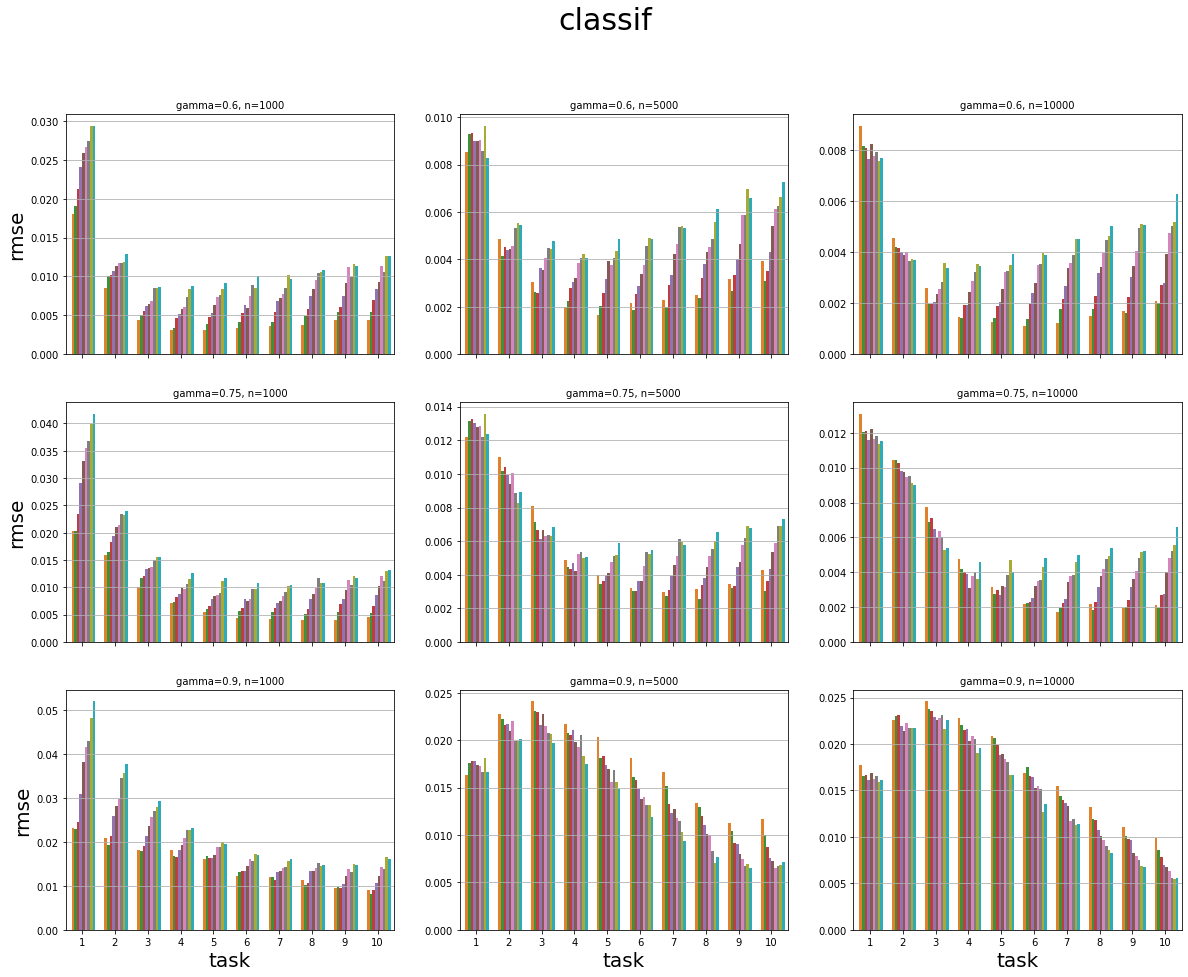

In [11]:
neighbours('classif', neighbours_agg, 'rmse', log=False)

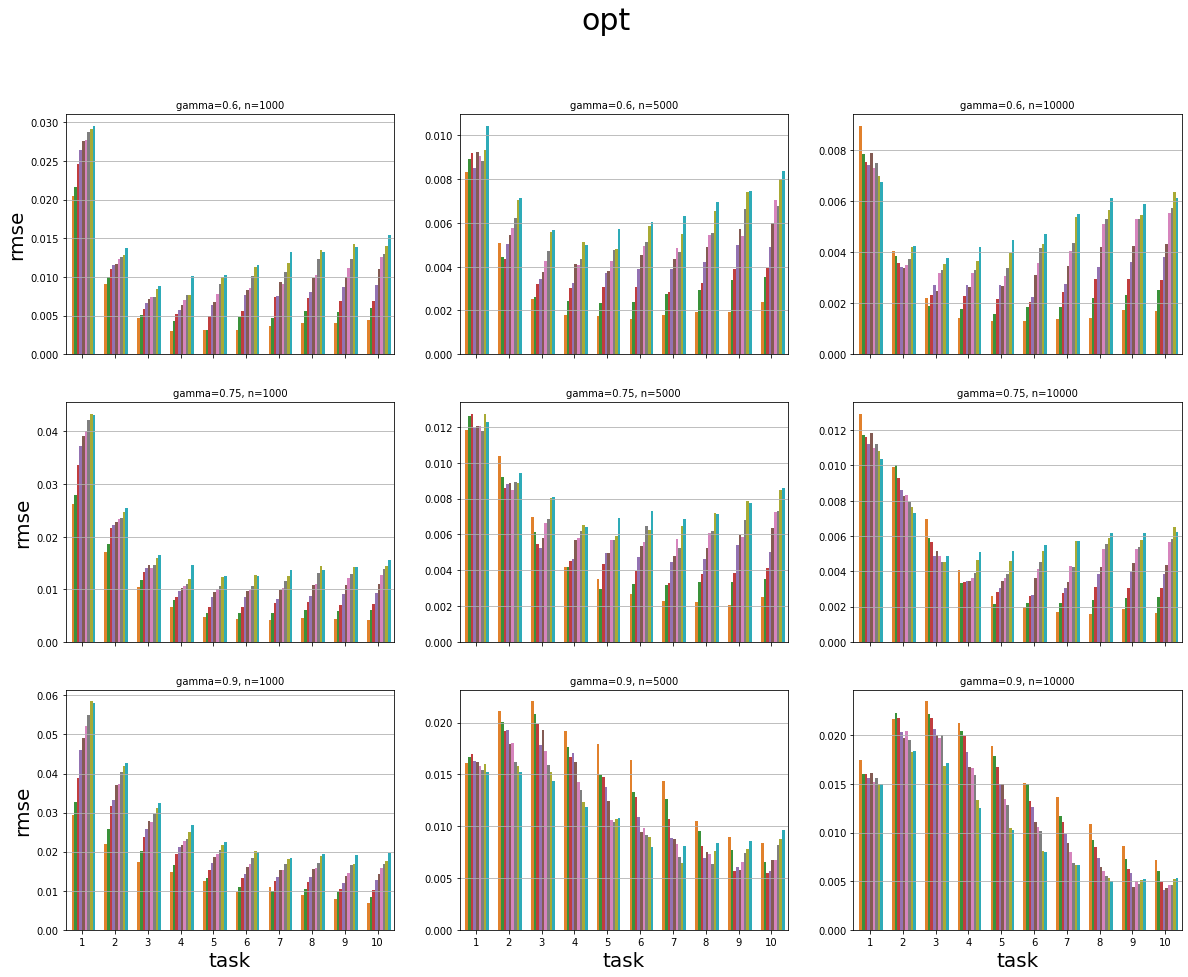

In [12]:
neighbours('opt', neighbours_agg, 'rmse', log=False)

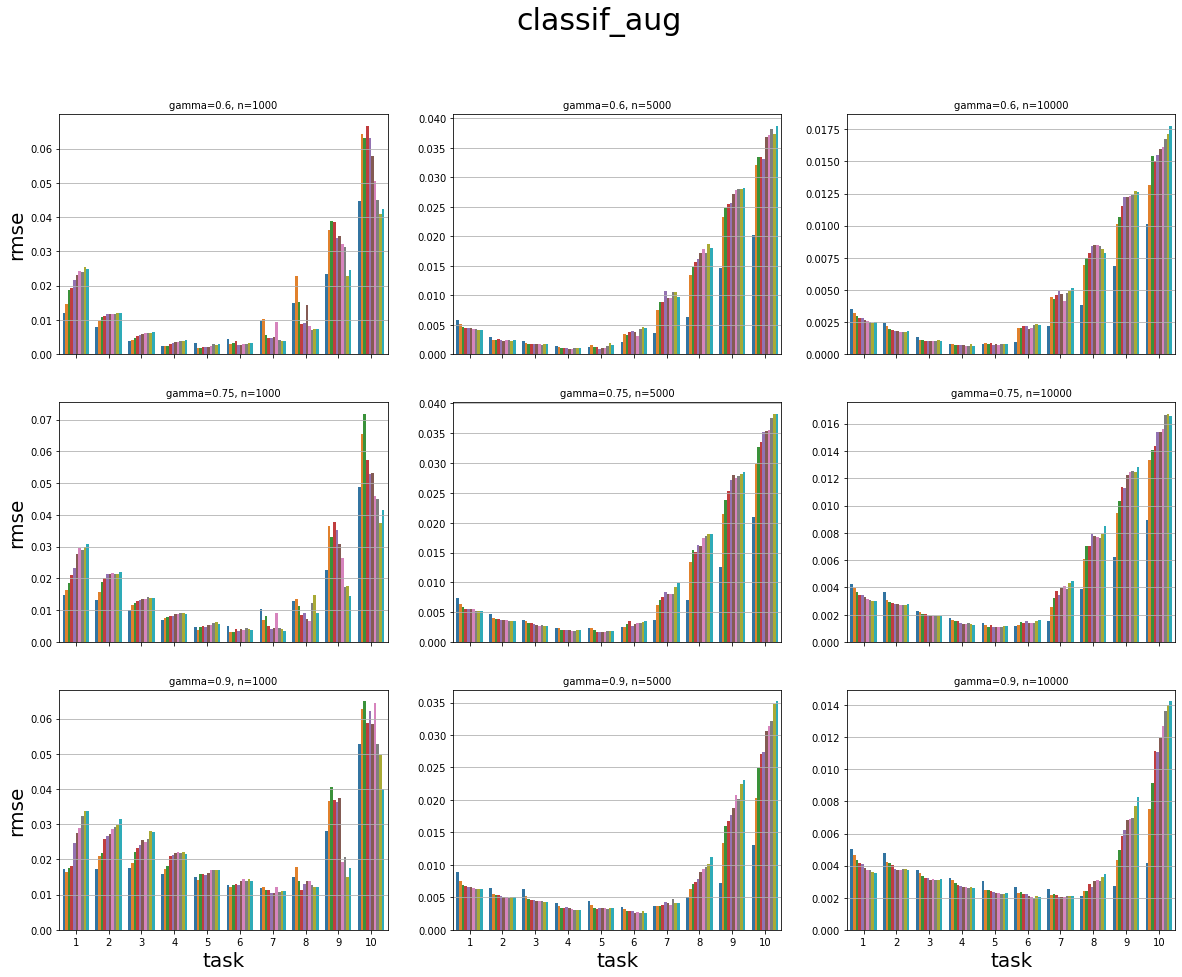

In [13]:
neighbours('classif_aug', neighbours_agg, 'rmse', log=False)

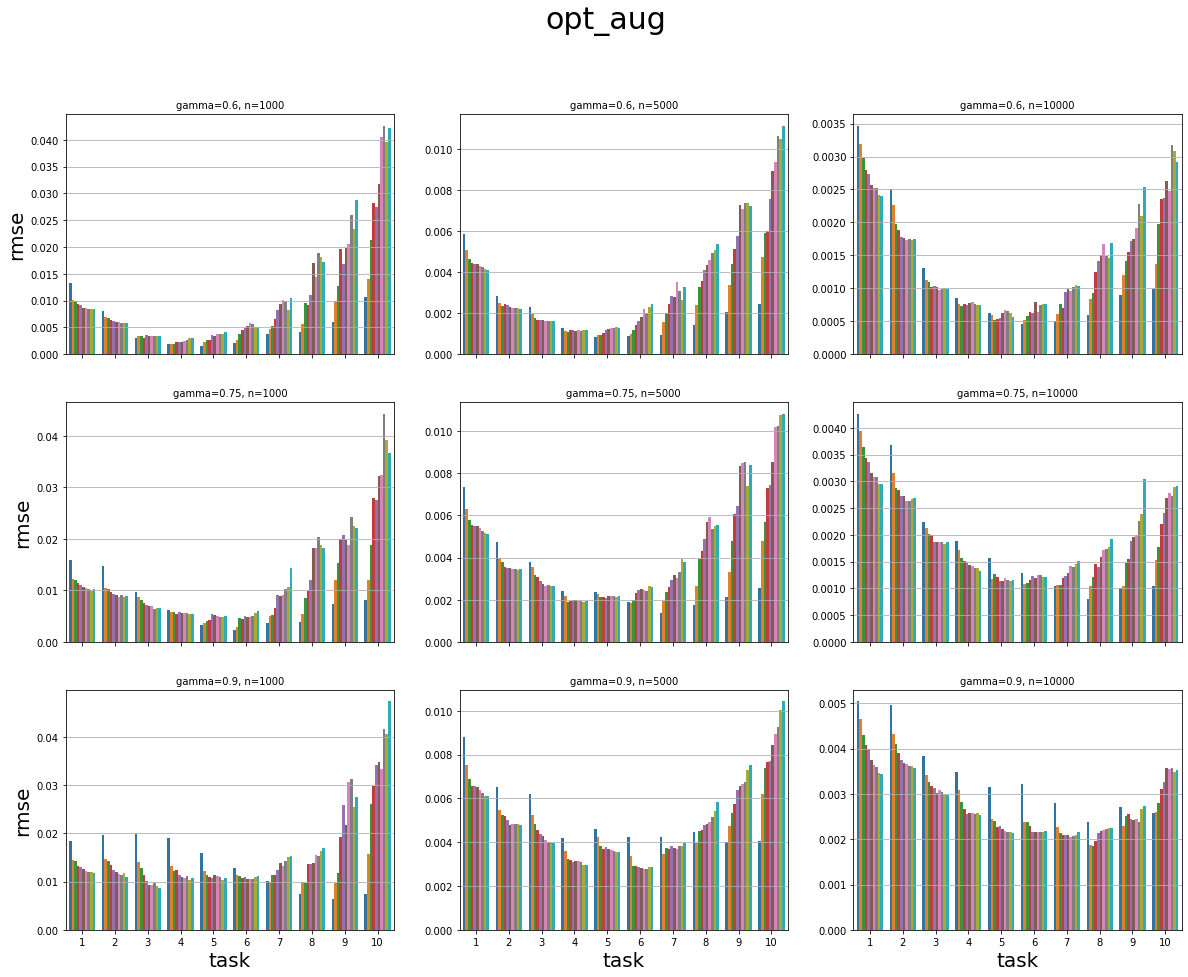

In [14]:
neighbours('opt_aug', neighbours_agg, 'rmse', log=False)

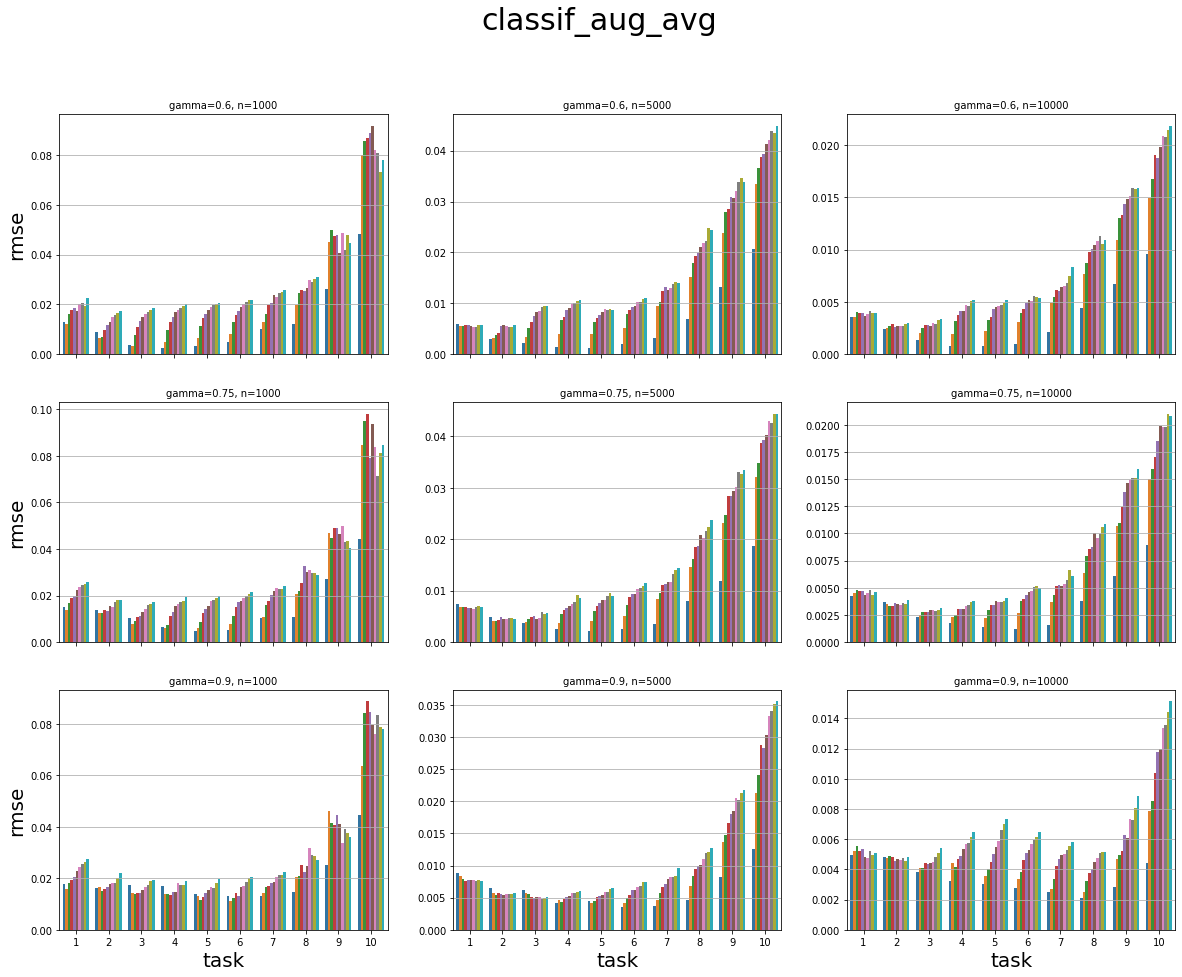

In [15]:
neighbours('classif_aug_avg', neighbours_agg, 'rmse', log=False)

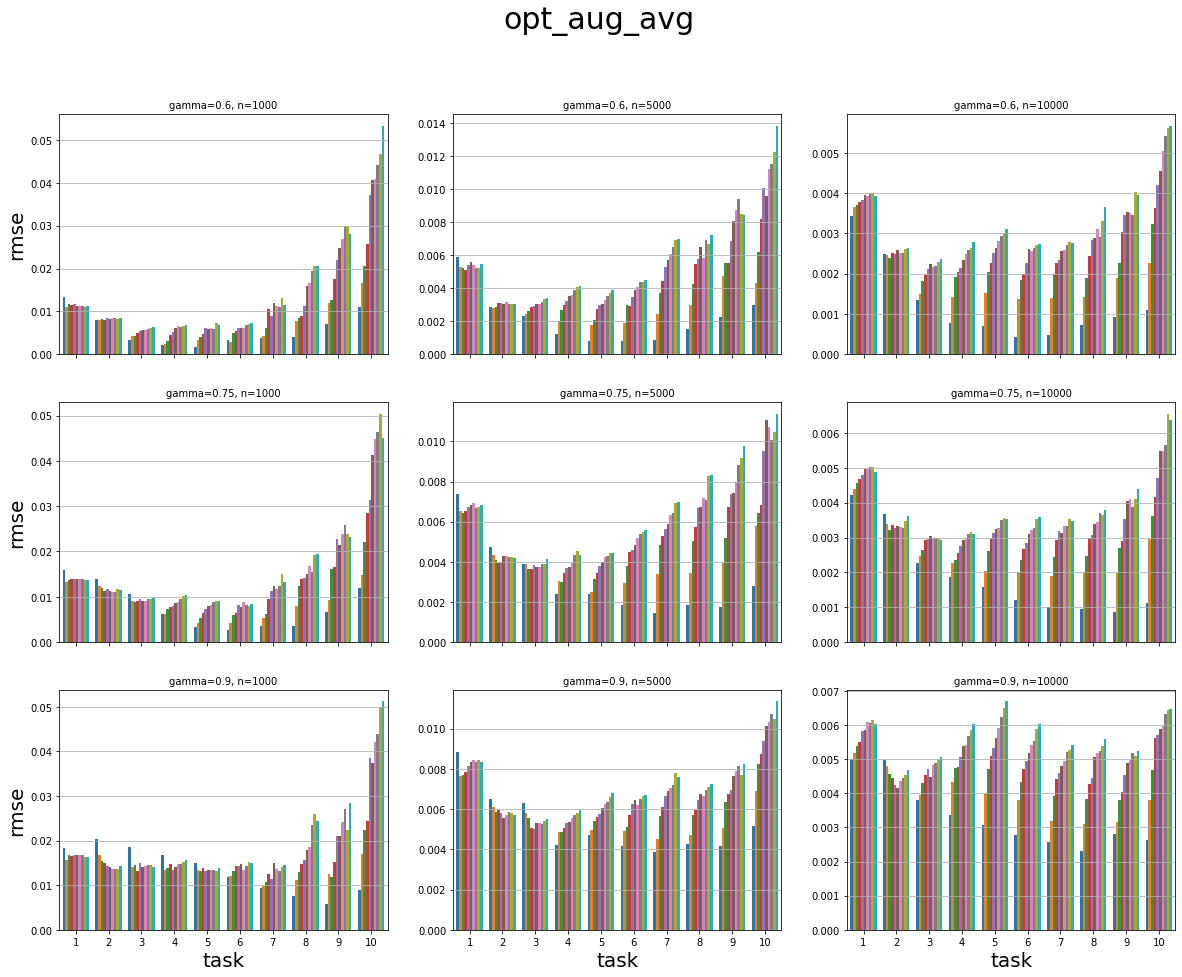

In [16]:
neighbours('opt_aug_avg', neighbours_agg, 'rmse', log=False)

### Rangi sąsiadów

Poniżej znajdują się uśrednione rangi sąsiadów dla wszystkich metod.

In [17]:
ranks = neighbours_rank(neighbours_agg)
ranks.groupby(['method', 'k'])['rank'].mean()

method           k 
classif          1     10.000000
                 2      3.966667
                 3      3.655556
                 4      4.144444
                 5      4.422222
                 6      4.788889
                 7      5.422222
                 8      5.866667
                 9      6.288889
                 10     6.444444
classif_aug      1      5.300000
                 2      5.433333
                 3      5.488889
                 4      5.433333
                 5      5.266667
                 6      5.155556
                 7      5.355556
                 8      5.544444
                 9      6.044444
                 10     5.977778
classif_aug_avg  1      2.144444
                 2      2.655556
                 3      3.611111
                 4      4.577778
                 5      5.322222
                 6      5.766667
                 7      6.644444
                 8      7.322222
                 9      8.133333
                 10    

In [18]:
r = ranks.groupby(['method', 'k'])['rank'].mean().reset_index().pivot('k', columns='method').round(2)
r.columns = r.columns.get_level_values(1)
r = r.loc[:, ['opt', 'classif', 'opt_aug', 'classif_aug', 'opt_aug_avg', 'classif_aug_avg']]

In [19]:
r

method,opt,classif,opt_aug,classif_aug,opt_aug_avg,classif_aug_avg
k,,,,,,
1,10.00,10.00,5.80,5.30,2.84,2.14
2,3.41,3.97,5.23,5.43,2.67,2.66
3,3.66,3.66,5.08,5.49,3.29,3.61
4,3.93,4.14,5.18,5.43,4.14,4.58
5,4.21,4.42,5.46,5.27,5.17,5.32
6,4.93,4.79,5.60,5.16,6.03,5.77
7,5.22,5.42,5.52,5.36,6.76,6.64
8,5.77,5.87,5.77,5.54,7.31,7.32
9,6.73,6.29,5.52,6.04,8.14,8.13


# Wybór najlepszej liczby sąsiadów

Od teraz wszystkie modele wymagające sąsiadów będą używały ich optymalnej liczby. Optymalna liczba jest zdefiniowa na dwa sposoby i oba rodzaje wyników są zaprezentowane poniżej.

Pierwszy rodzaj optymalnej liczby sąsiadów, to optymalna liczba sąsiadów dla danej metody i danego zadania. Czyli liczba sąsiadów znaleziona w wyniku przeszukiwania siatki parametrów.

Drugi rodzaj optymalnej liczby sąsiadów, to średnio najlepsza liczba sąsiadów dla danej metody (uśredniając po taskach). Ten sposób daje nam domyślną wartość sąsiadów.

In [20]:
def choose_best(per):
    if per == 'method_and_task':
        best_ranks_per_method_and_task = ranks.sort_values('rank').groupby(['gamma', 'n', 'c', 'method']).head(1).drop(columns='rank')
        cmis_best = []
        for i, b in best_ranks_per_method_and_task.iterrows():
            cmis_best.append(cmis_neighbours.set_index(['gamma', 'n', 'c', 'method', 'k']).loc[b['gamma'], b['n'], b['c'], b['method'], b['k']])

        cmis_best = pd.concat(cmis_best)
        cmis_best = cmis_best.reset_index().drop(columns='k').set_index(['gamma', 'n', 'c', 'method'])
        return cmis_best, best_ranks_per_method_and_task
    if per == 'method':
        best_ranks_per_method = ranks.groupby(['method', 'k'])['rank'].mean().reset_index().sort_values('rank').groupby(['method']).first().k.to_dict()
        cmis_best = []
        for k, v in best_ranks_per_method.items():
            cmis_best.append(cmis_neighbours.set_index(['method', 'k']).loc[k, v])
        cmis_best = pd.concat(cmis_best)
        cmis_best = cmis_best.reset_index().drop(columns='k').set_index(['gamma', 'n', 'c', 'method'])
        return cmis_best, best_ranks_per_method

# Porównania zbiorcze: sąsiedzi + różnice + KSG

Tutaj są przedstawione już ogólne wyniki dla wszystkich metod. KSG jest użyte zawsze z domyślną liczbą 5 sąsiadów. CMI w przypadku KSG jest policzone używając wzoru na różnicę.

In [21]:
def plot_errors(name):
    fig, ax = plt.subplots(3, 3)
    for i, gamma in enumerate([0.6, 0.75, 0.9]):
        for j, n in enumerate([1000, 5000, 10_000]):
            plt.subplot(3, 3, i*3+j+1)
            ax[i][j].set_yscale('log')
            sns.barplot(x='method', y='residual', hue='c', data=cmis_joint.loc[gamma, n].reset_index().sort_values('method'), estimator=lambda x: np.sqrt(np.mean(x**2)),
                       order=['classif', 'opt', 'classif_aug', 'opt_aug', 'classif_aug_avg', 'opt_aug_avg', 'diff_classif', 'diff_opt', 'ksg'], ax=ax[i][j], errwidth=1)
            ax[i][j].get_legend().remove()
            ax[i][j].set_xlabel(None)
            ax[i][j].set_ylabel('rmse')
            ax[i][j].tick_params(axis='x', rotation=30)

            l, u = ax[i][j].get_ylim()
            ax[i][j].set_yticks(2 ** np.linspace(np.log2(l), np.log2(u), 10))
            ax[i][j].set_yticklabels([f'{x:.1}' for x in 2 ** np.linspace(np.log2(l), np.log2(u), 10)])
            ax[i][j].grid(axis='y')
    plt.savefig(f'plots/errors/errors_{name}.png', bbox_inches='tight')
    
def plot_predictions(name):
    for i, gamma in enumerate([0.6, 0.75, 0.9]):
        for j, n in enumerate([1000, 5000, 10_000]):
            plt.subplot(3, 3, i*3+j+1)
            sns.lineplot(x='c', y='estimation', hue='method', data=cmis_joint.loc[gamma, n].reset_index().sort_values('method'))
            plt.plot(range(1, 11), [GTM(11, gamma).mi(c) for c in range(1, 11)], color='black', linestyle='--')
            plt.title(f'{gamma}, {n}')
            
    plt.savefig(f'plots/predictions/predictions_{name}.png', bbox_inches='tight')
    
def plot_selected_predictions(methods, name):
    fig, ax = plt.subplots(3, 3, sharey='row')
    for i, gamma in enumerate([0.6, 0.75, 0.9]):
        for j, n in enumerate([1000, 5000, 10_000]):
            tmp = cmis_joint.loc[gamma, n].reset_index()
            tmp = tmp.loc[np.isin(tmp.method, methods)]
            
            main = sns.lineplot(x='c', y='estimation', hue='method', data=tmp.sort_values('method'), ax=ax[i][j])
            add = sns.lineplot(range(1, 11), [GTM(11, gamma).mi(c) for c in range(1, 11)], color='black', linestyle='--', ax=ax[i][j], label='true CMI')
            
            if i != 2:
                ax[i][j].set_xlabel(None)
            else:
                ax[i][j].set_xlabel('task')
            if j != 0:
                ax[i][j].set_ylabel(None)
            else:
                ax[i][j].set_ylabel('estimation')
            ax[i][j].set_xticks(range(1, 11))
            ax[i][j].grid(axis='x')
            
            ax[i][j].set_title(f'gamma={gamma}, n={n}')
    plt.savefig(f'plots/predictions/predictions_{"-".join(methods)}_{name}.png', bbox_inches='tight')

### Optymalna liczba sąsiadów dla metody i zadania

In [22]:
cmis_best, _ = choose_best('method_and_task')
cmis_joint = pd.concat((cmis_diffs.set_index(['gamma', 'n', 'c', 'method']), cmis_best, cmis_ksg.set_index(['gamma', 'n', 'c', 'method'])))

##### Błędy RMSE

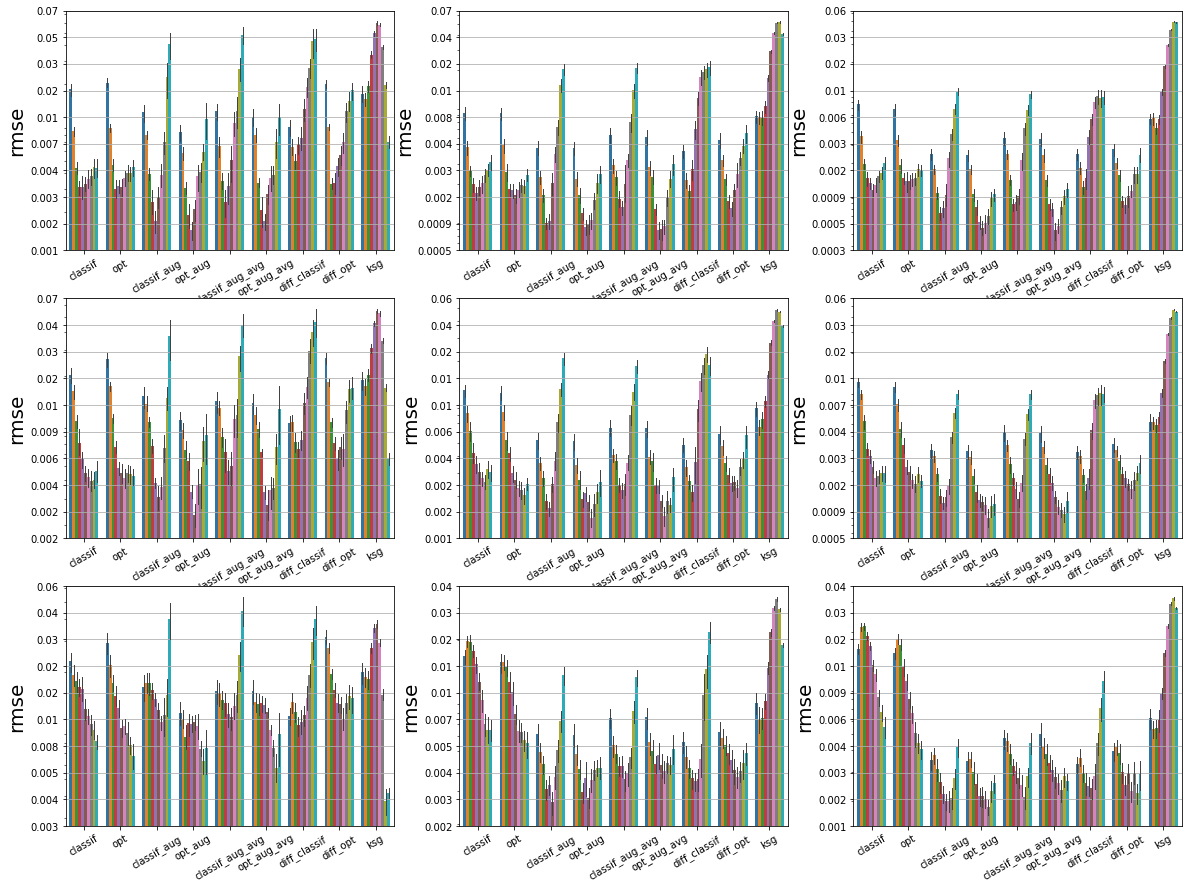

In [23]:
plot_errors('best')

##### Zestawienie estymacji

Tutaj są zestawione estymacje ze wszystkich metod. Przerywana czarna linia przedstawia wartość teoretyczną. Przedziały ufności to 95%.

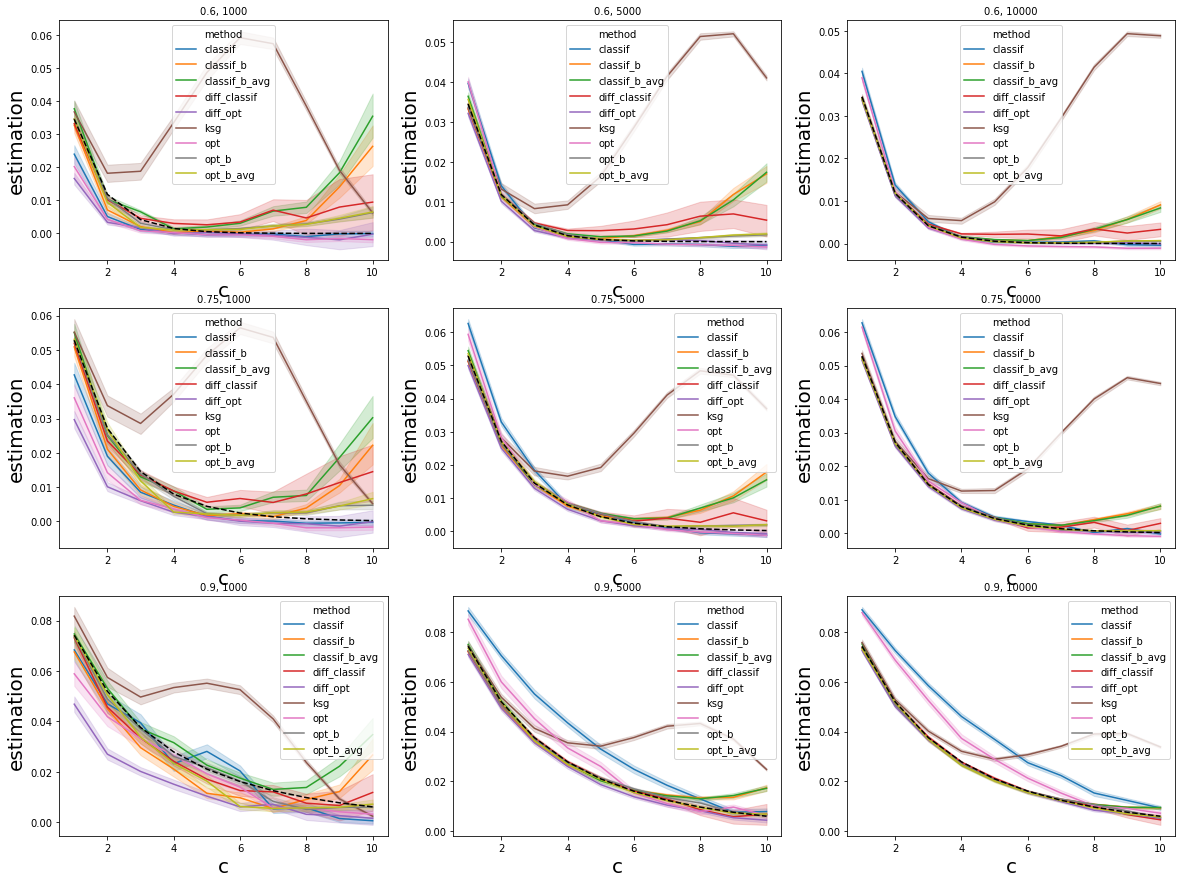

In [50]:
plot_predictions('best')

##### Zestawienie estymacji dla dwóch moim zdaniem najlepiej działających modeli

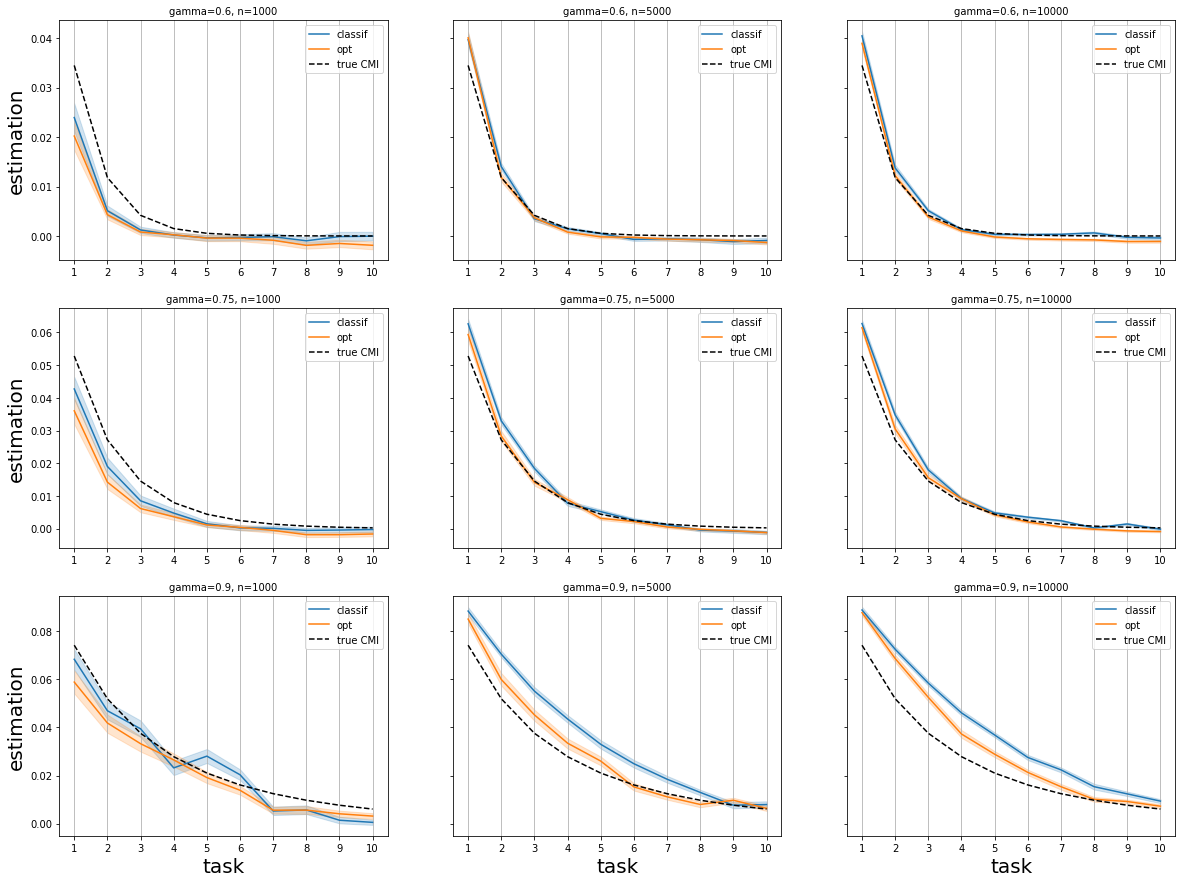

In [24]:
plot_selected_predictions(['classif', 'opt'], 'best')

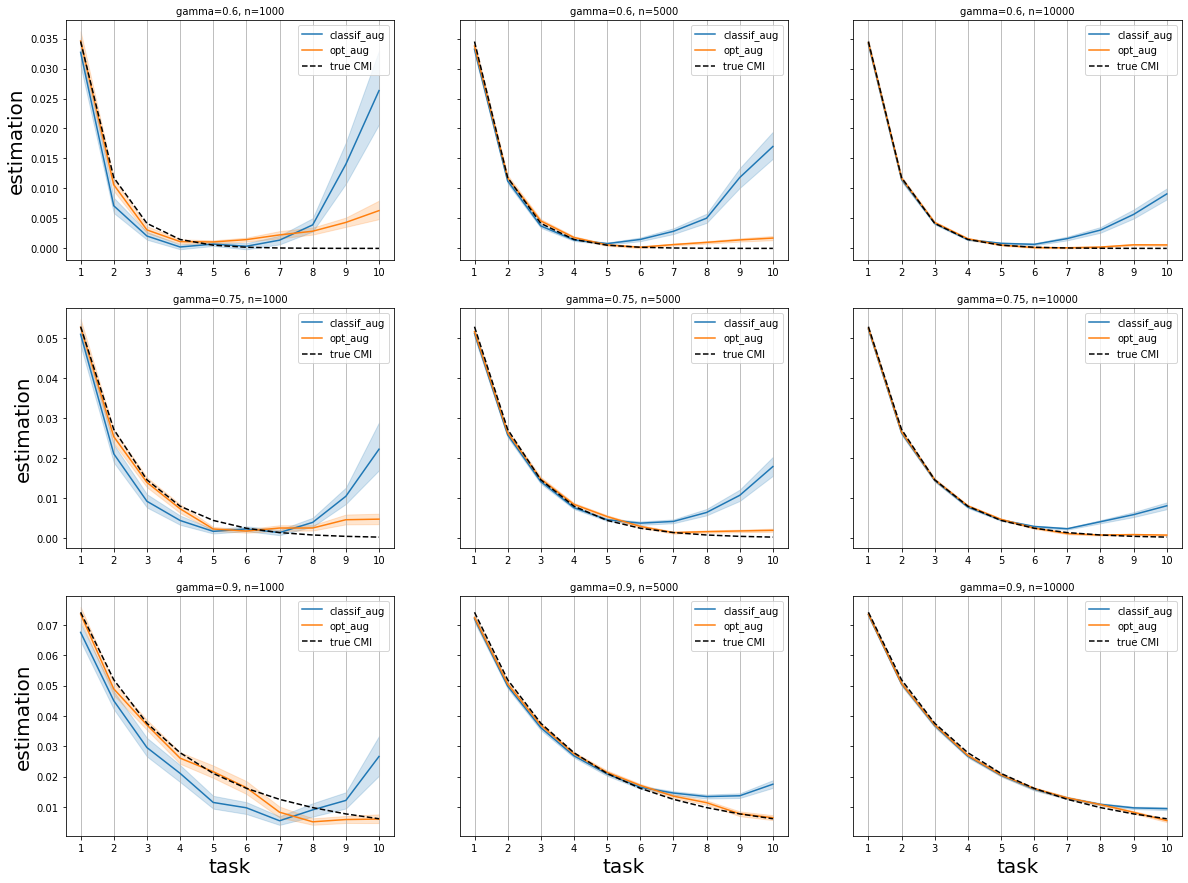

In [25]:
plot_selected_predictions(['classif_aug', 'opt_aug'], 'best')

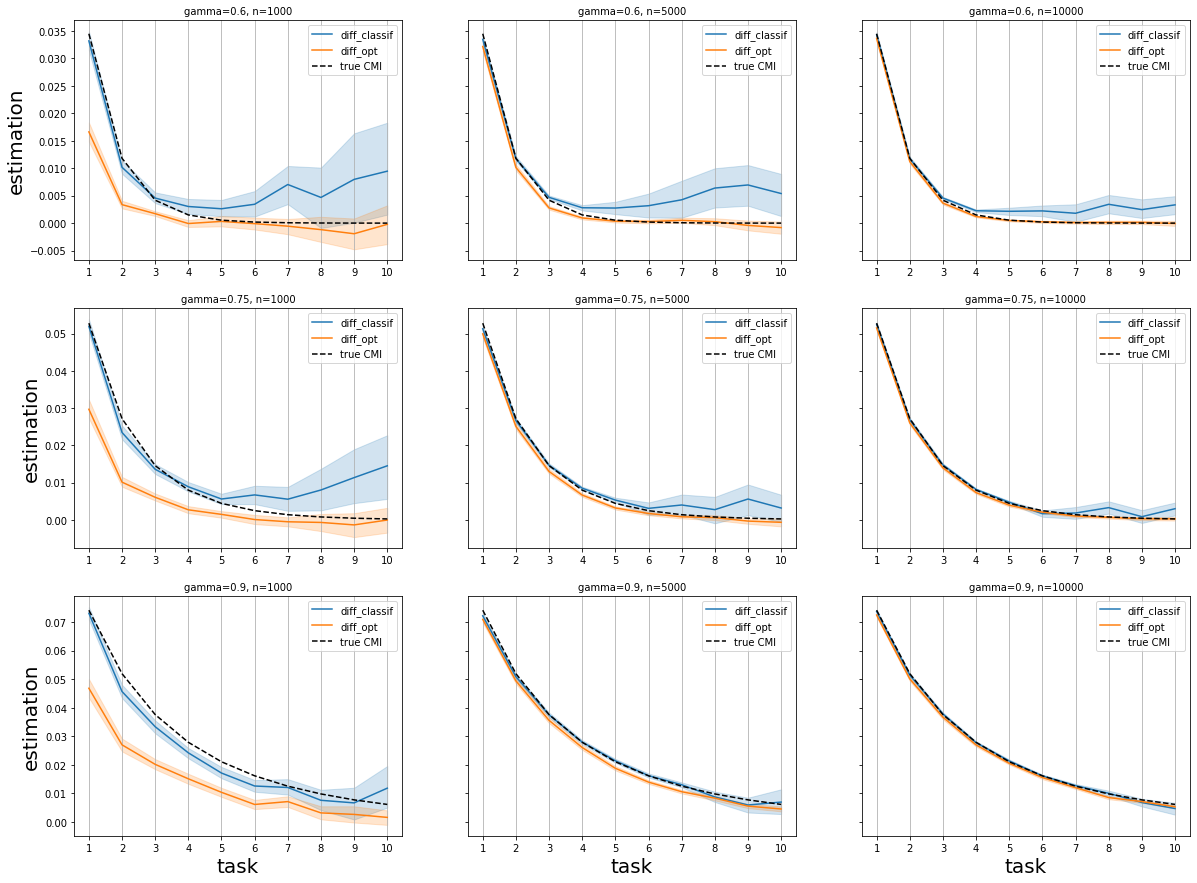

In [26]:
plot_selected_predictions(['diff_opt', 'diff_classif'], 'best')

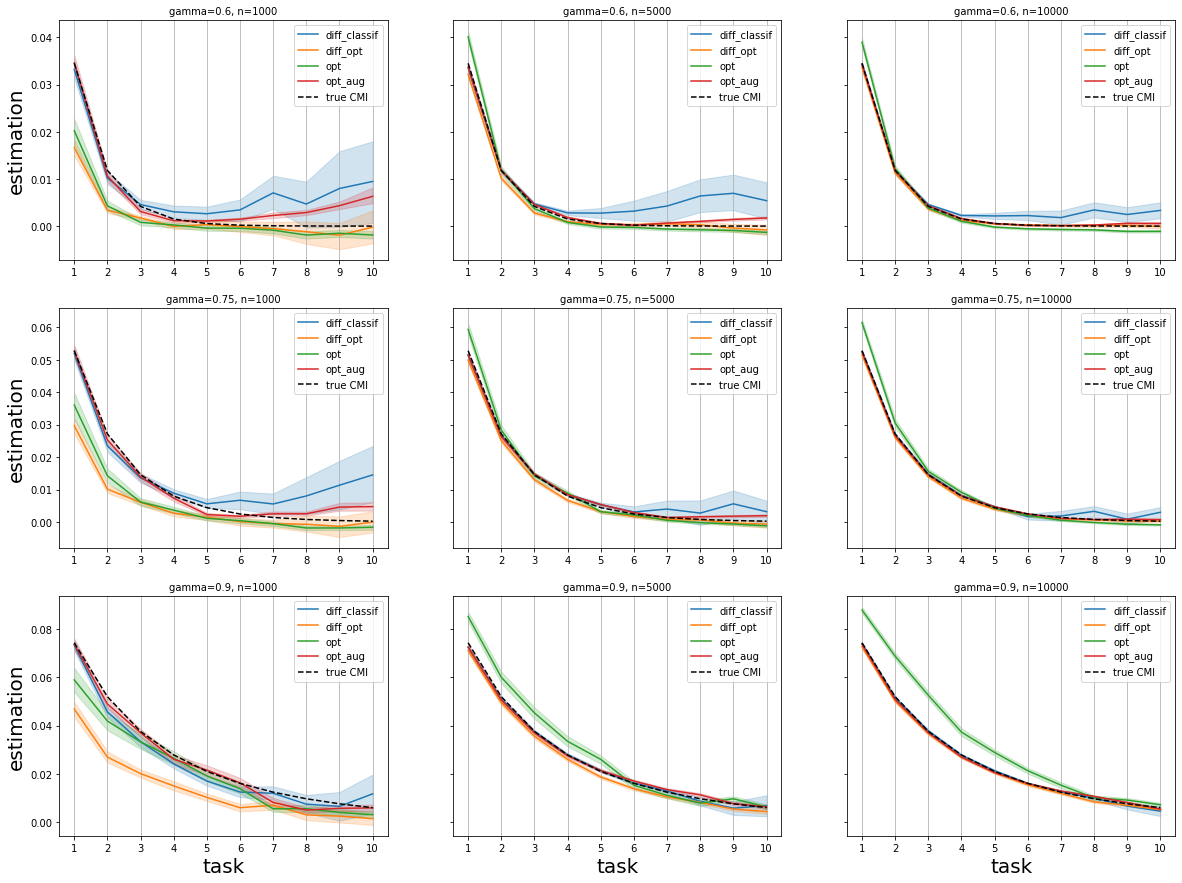

In [27]:
plot_selected_predictions(['opt', 'opt_aug', 'diff_classif', 'diff_opt'], 'best')

### Optymalna liczba sąsiadów dla metody (wartość domyślna)

In [26]:
cmis_best, defaults = choose_best('method')
cmis_joint = pd.concat((cmis_diffs.set_index(['gamma', 'n', 'c', 'method']), cmis_best, cmis_ksg.set_index(['gamma', 'n', 'c', 'method'])))

In [27]:
defaults

{'classif': 3,
 'classif_b': 6,
 'classif_b_avg': 1,
 'opt': 2,
 'opt_b': 3,
 'opt_b_avg': 2}

##### Błędy RMSE

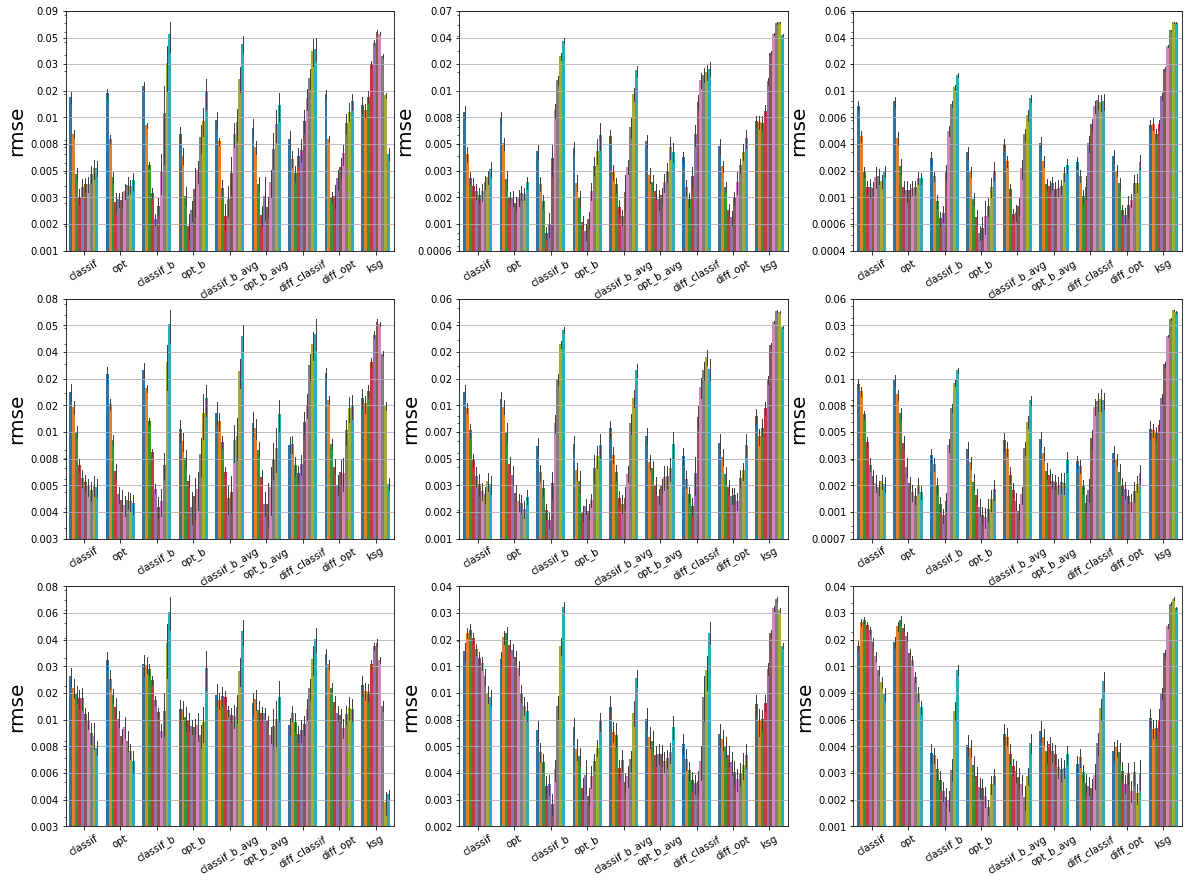

In [28]:
plot_errors()

##### Zestawienie estymacji

Tutaj są zestawione estymacje ze wszystkich metod. Przerywana czarna linia przedstawia wartość teoretyczną. Przedziały ufności to 95%.

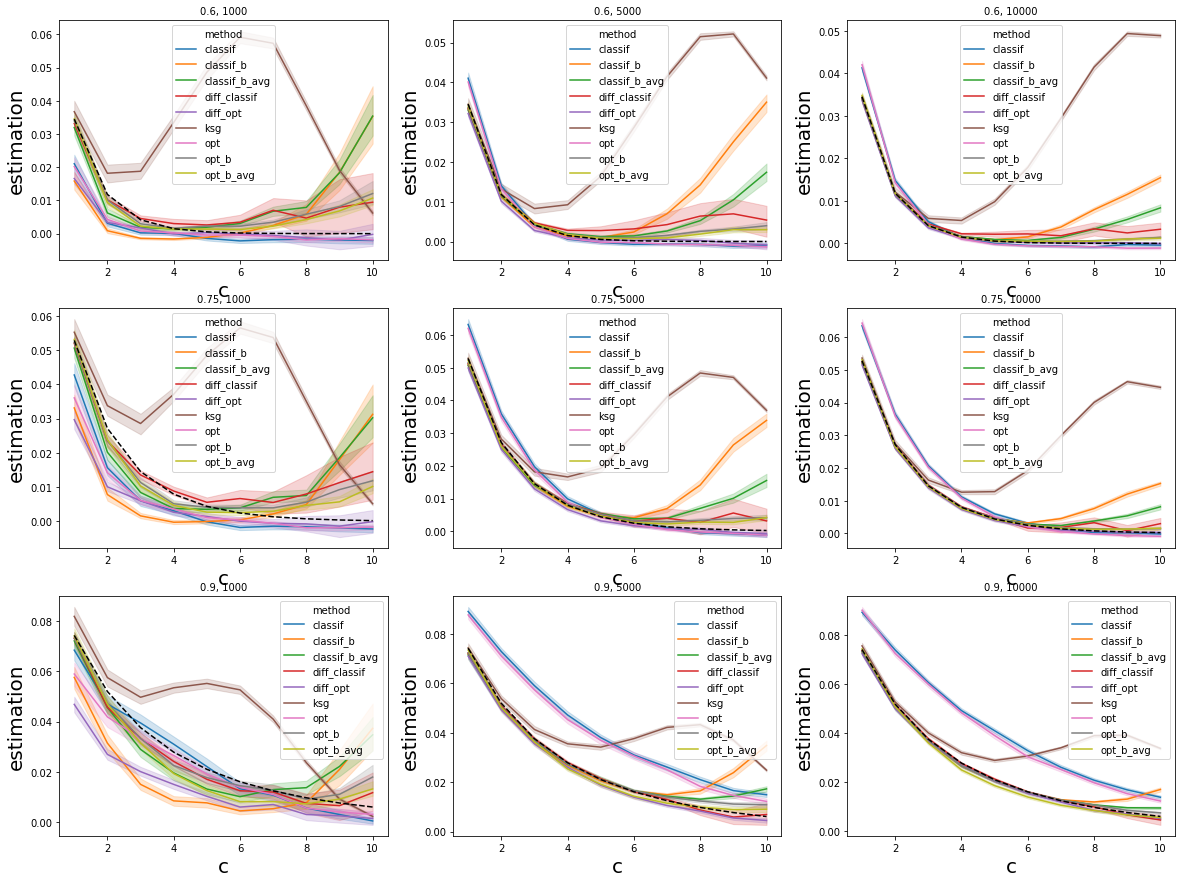

In [29]:
plot_predictions()

##### Zestawienie estymacji dla dwóch moim zdaniem najlepiej działających modeli

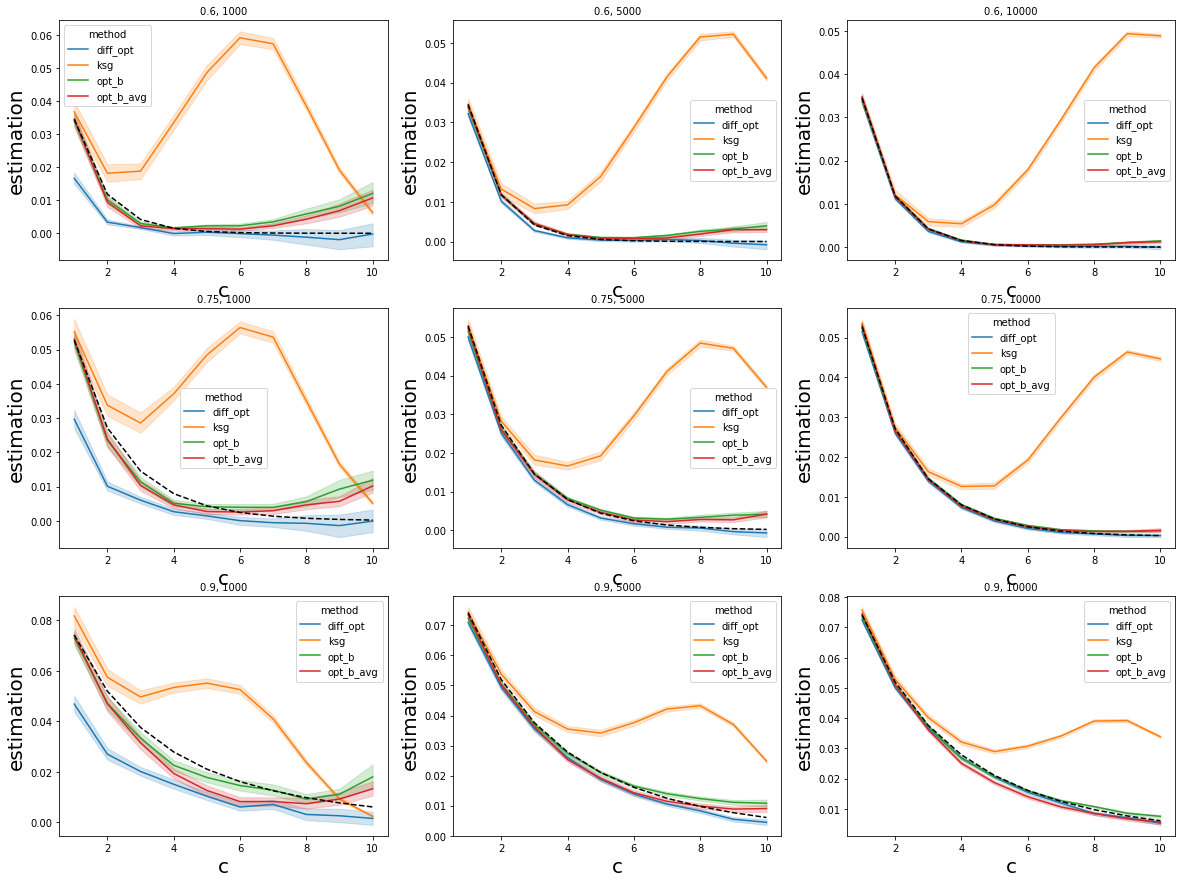

In [30]:
plot_selected_predictions(['opt_b', 'opt_b_avg', 'diff_opt', 'ksg'])